# Cyclone tropical Nadine (septembre 2012) : analyse en composantes principales et clustering de la prévision d'ensemble ECMWF

Auteur : FERRY Frédéric (ENM/C3M) - Mars 2022

Cas du cyclone tropical Nadine sur l'Alantique. Prévision d'ensemble à +96h du run du 20/09/2012 0000UTC.

Concepts Python illustrés :

- Exploitation de fichiers netcdf (xarray)
- Tracé de cartes (matplotlib, cartopy)
- Analyse en composantes principales (package eofs)
- Classification (package sklearn)
- Réalisation de composites

In [17]:
%matplotlib inline

import os
import numpy as np

import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from eofs.standard import Eof
from sklearn.cluster import KMeans

In [2]:
# Analysis data
Ana_Z500 = './data/Z500_September2012_HiRes.nc'
Ana_MSLP = './data/MSLP_September2012_HiRes.nc'
# Analysis time
t0 ='2012-09-20T00:00:00.000000000'
t0_str=t0[0:13]

# Ensemble data
EPS_Z500 = './data/EPS_2012092000_Z500.nc'
EPS_MSLP = './data/EPS_2012092000_MSLP.nc'
members = np.linspace(1, 50, 50)
members_str = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15',
	'16','17','18','19','20','21','22','23','24','25',
	'26','27','28','29','30','31','32','33','34','35',
	'36','37','38','39','40','41','42','43','44','45','46','47','48','49','50']
# Forecast time
date = '2012-09-24T00:00:00.000000000'
date_str=date[0:13]

# EOF and clustering
neofs=2
nclusters=2
# Domain for EOF analysis
minlat = 35.
maxlat = 55.
minlon = -10.
maxlon = 20.

# Domain for field plots
latS = 20.
latN = 70.
lonW = -60.
lonE = 30.

# Partie 1 : étude des données d'analyse

In [3]:
data_z    = xr.open_dataset(Ana_Z500)
data_mslp   = xr.open_dataset(Ana_MSLP)

print(data_z)
print(data_mslp)

<xarray.Dataset>
Dimensions:  (lon: 301, lat: 121, lev: 1, time: 120)
Coordinates:
  * lon      (lon) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 58.5 59.0 59.5 60.0
  * lat      (lat) float64 80.0 79.5 79.0 78.5 78.0 ... 22.0 21.5 21.0 20.5 20.0
  * lev      (lev) float64 5e+04
  * time     (time) datetime64[ns] 2012-09-01 ... 2012-09-30T18:00:00
Data variables:
    var129   (time, lev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.4.3
    Conventions:  CF-1.0
    history:      Tue Aug 20 18:22:29 2019: cdo -f nc copy Z500_September2012...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.4.3 (http://www.mpimet.mpg...
<xarray.Dataset>
Dimensions:  (lon: 1067, lat: 429, time: 120)
Coordinates:
  * lon      (lon) float64 -90.14 -90.0 -89.86 -89.72 ... 59.88 60.02 60.16
  * lat      (lat) float64 80.22 80.08 79.94 79.8 ... 20.3 20.16 20.02 19.87
  * time     (time) datetime64[ns] 20

In [4]:
data_z    = xr.open_dataset(Ana_Z500).sel(lat=slice(latN,latS)).sel(lon=slice(lonW,lonE)).sel(time=t0).squeeze()
data_mslp   = xr.open_dataset(Ana_MSLP).sel(lat=slice(latN,latS)).sel(lon=slice(lonW,lonE)).sel(time=t0).squeeze()

print(data_z)
print(data_mslp)

lats_z = data_z.lat.values
lons_z = data_z.lon.values
lats_mslp = data_mslp.lat.values
lons_mslp = data_mslp.lon.values

z_ana = data_z['var129']/9.81
mslp_ana = data_mslp['var151']/100

print(z_ana)
print(mslp_ana)

<xarray.Dataset>
Dimensions:  (lon: 181, lat: 101)
Coordinates:
  * lon      (lon) float64 -60.0 -59.5 -59.0 -58.5 -58.0 ... 28.5 29.0 29.5 30.0
  * lat      (lat) float64 70.0 69.5 69.0 68.5 68.0 ... 22.0 21.5 21.0 20.5 20.0
    lev      float64 5e+04
    time     datetime64[ns] 2012-09-20
Data variables:
    var129   (lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.4.3
    Conventions:  CF-1.0
    history:      Tue Aug 20 18:22:29 2019: cdo -f nc copy Z500_September2012...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.4.3 (http://www.mpimet.mpg...
<xarray.Dataset>
Dimensions:  (lon: 639, lat: 355)
Coordinates:
  * lon      (lon) float64 -59.97 -59.83 -59.69 -59.55 ... 29.71 29.85 29.99
  * lat      (lat) float64 69.93 69.79 69.65 69.51 ... 20.44 20.3 20.16 20.02
    time     datetime64[ns] 2012-09-20
Data variables:
    var151   (lat, lon) float32 ...
Attributes:
    CDI:   

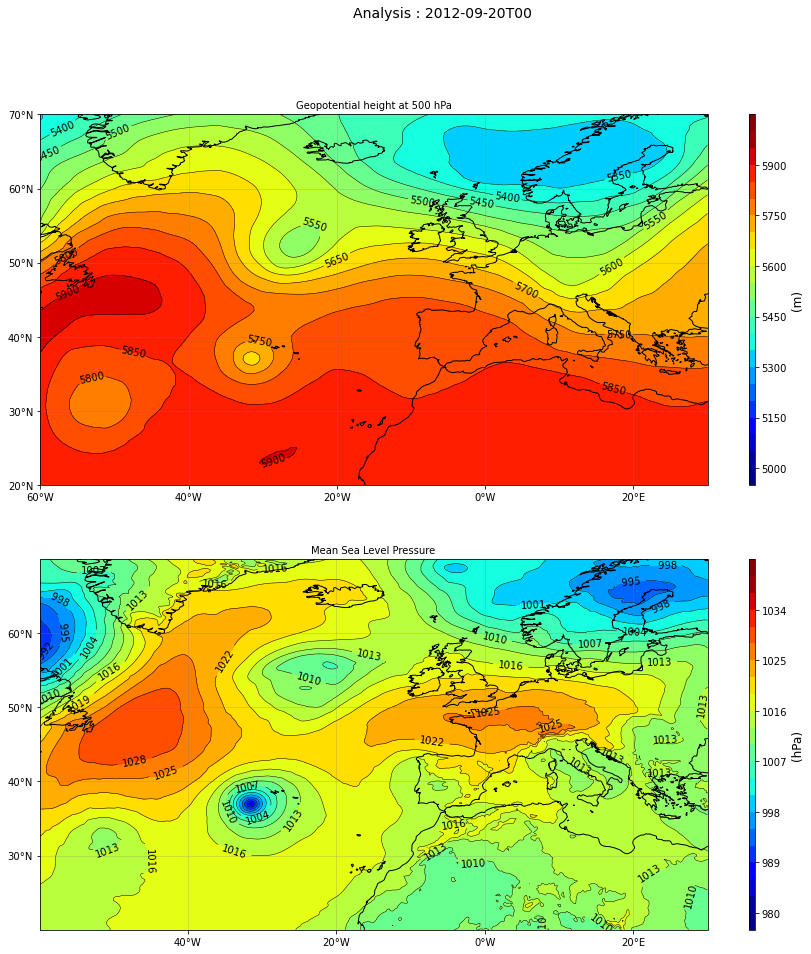

In [23]:
def plot_background(ax):
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    ax.set_xticks(np.linspace(-180, 180, 19), crs=projection)
    ax.set_yticks(np.linspace(-90, 90, 19), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    return ax

cmap='jet'
clevs1 = np.linspace(5000, 6000, 21)
clevs2 = np.linspace(980, 1040, 21)

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Analysis : '+t0_str, fontsize=14)

ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
plt.title('Geopotential height at 500 hPa', size=10, loc='center')
cf = ax.contourf(lons_z, lats_z, z_ana, levels=clevs1, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
plot_background(ax)
c = ax.contour(lons_z, lats_z, z_ana, levels=clevs1, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
ax.clabel(c, fmt='%4.1i', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('(m)', fontsize=12)

ax = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())
plt.title('Mean Sea Level Pressure', fontsize=10, loc='center')
plot_background(ax)
cf = ax.contourf(lons_mslp, lats_mslp, mslp_ana, levels=clevs2, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
c = ax.contour(lons_mslp, lats_mslp, mslp_ana, levels=clevs2, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
ax.clabel(c, fmt='%4.1i', fontsize=10)
cb.set_label('(hPa)', fontsize=12)

plt.show()

figname='./figs/Z500_MSLP_'+t0_str
fig.savefig(figname+'.png')

# Partie 2 : étude des données de prévision d'ensemble

In [7]:
z_eps    = xr.open_dataset(EPS_Z500)
mslp_eps   = xr.open_dataset(EPS_MSLP)
print(z_eps)
print(mslp_eps)

<xarray.Dataset>
Dimensions:  (lon: 301, lat: 121, lev: 1, time: 1050)
Coordinates:
  * lon      (lon) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 58.5 59.0 59.5 60.0
  * lat      (lat) float64 80.0 79.5 79.0 78.5 78.0 ... 22.0 21.5 21.0 20.5 20.0
  * lev      (lev) float64 5e+04
  * time     (time) datetime64[ns] 2012-09-20 2012-09-20 ... 2012-09-30
Data variables:
    var129   (time, lev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.4.3
    Conventions:  CF-1.0
    history:      Tue Aug 20 18:21:47 2019: cdo -f nc copy EPS_2012092000_Z50...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.4.3 (http://www.mpimet.mpg...
<xarray.Dataset>
Dimensions:  (lon: 535, lat: 215, time: 2050)
Coordinates:
  * lon      (lon) float64 -90.0 -89.72 -89.44 -89.16 ... 59.49 59.77 60.05
  * lat      (lat) float64 80.16 79.88 79.59 79.31 ... 20.87 20.58 20.3 20.02
  * time     (time) datetime64[ns

In [8]:
z_eps    = xr.open_dataset(EPS_Z500).sel(lat=slice(latN,latS)).sel(lon=slice(lonW,lonE)).sel(time=date).squeeze()
mslp_eps    = xr.open_dataset(EPS_MSLP).sel(lat=slice(latN,latS)).sel(lon=slice(lonW,lonE)).sel(time=date).squeeze()

lats_z0 = z_eps.lat.values
lons_z0 = z_eps.lon.values
lats_mslp0 = mslp_eps.lat.values
lons_mslp0 = mslp_eps.lon.values

z_ens=z_eps['var129']/9.81
mslp_ens=mslp_eps['var151']/100

print(z_ens)
print(mslp_ens)

<xarray.DataArray 'var129' (time: 50, lat: 101, lon: 181)>
array([[[5420.0693, 5419.292 , 5418.387 , ..., 5431.1934, 5429.231 ,
         5427.2812],
        [5427.9824, 5427.243 , 5426.3896, ..., 5424.733 , 5422.783 ,
         5420.834 ],
        [5435.2705, 5434.557 , 5433.7417, ..., 5418.209 , 5416.1577,
         5414.1313],
        ...,
        [5897.6943, 5898.4077, 5899.3633, ..., 5855.2246, 5854.269 ,
         5853.7466],
        [5895.987 , 5897.0825, 5898.395 , ..., 5854.868 , 5853.989 ,
         5853.721 ],
        [5895.2095, 5896.5854, 5898.0894, ..., 5854.511 , 5853.632 ,
         5853.5044]],

       [[5481.376 , 5482.013 , 5482.6377, ..., 5468.9014, 5467.245 ,
         5465.5884],
        [5481.045 , 5482.0513, 5483.032 , ..., 5472.342 , 5470.6343,
         5468.94  ],
        [5480.2676, 5481.72  , 5483.1216, ..., 5476.534 , 5474.7373,
         5473.0044],
...
        [5889.5186, 5889.799 , 5889.99  , ..., 5873.884 , 5874.419 ,
         5874.6357],
        [5889.047 , 58

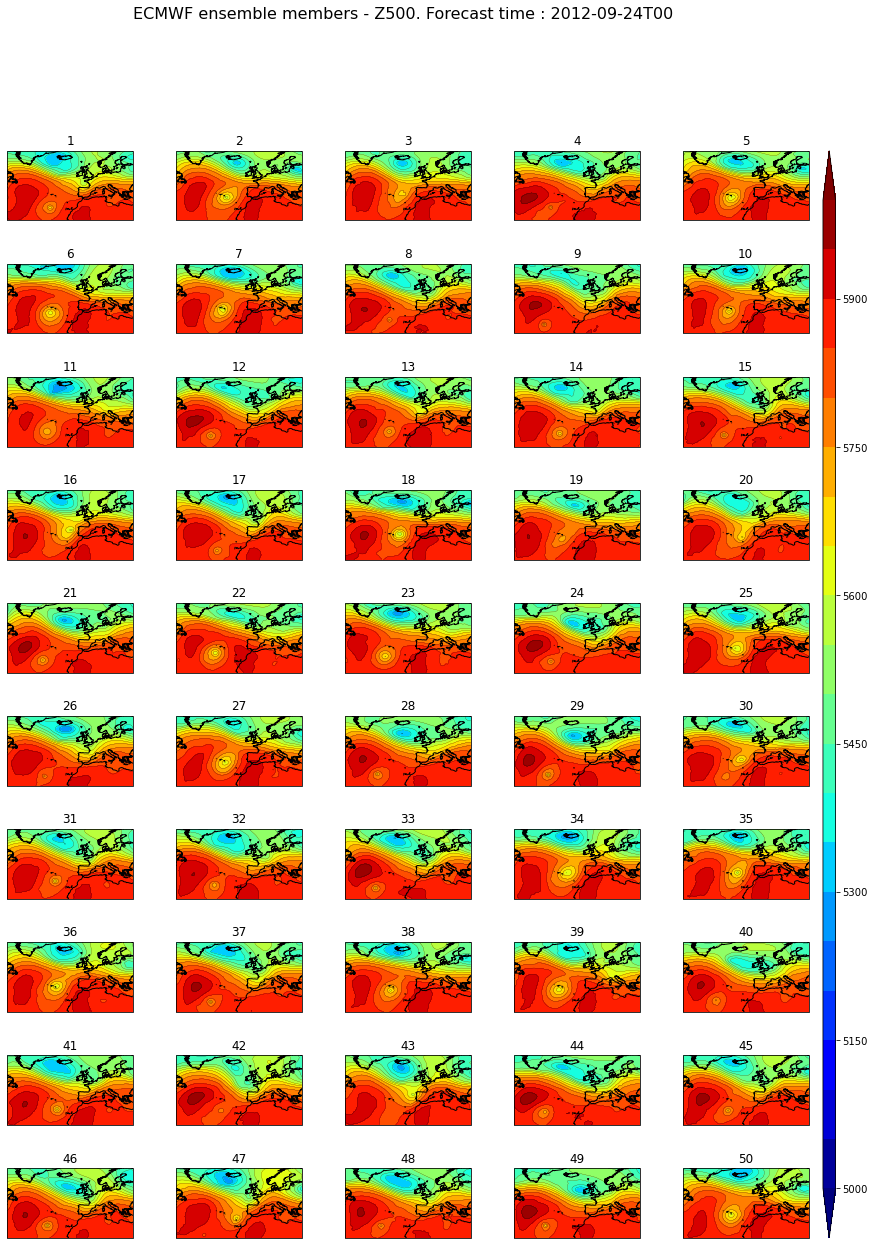

In [31]:
plt_title = 'ECMWF ensemble members - Z500. Forecast time : '+date_str
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(20,20))
fig.suptitle(plt_title, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(10, 5),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='1%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    ax.coastlines()
    ax.set_title(str(i+1), fontsize=12)
    p1 = ax.contourf(lons_z0, lats_z0, z_ens[i,:,:], clevs1, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
    p2 = ax.contour(lons_z0, lats_z0, z_ens[i,:,:], clevs1, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())
    axgr.cbar_axes[i].colorbar(p1)

plt.show()

figname='./figs/z500_ENS_'+date_str
fig.savefig(figname+'.pdf')
fig.savefig(figname+'.png')

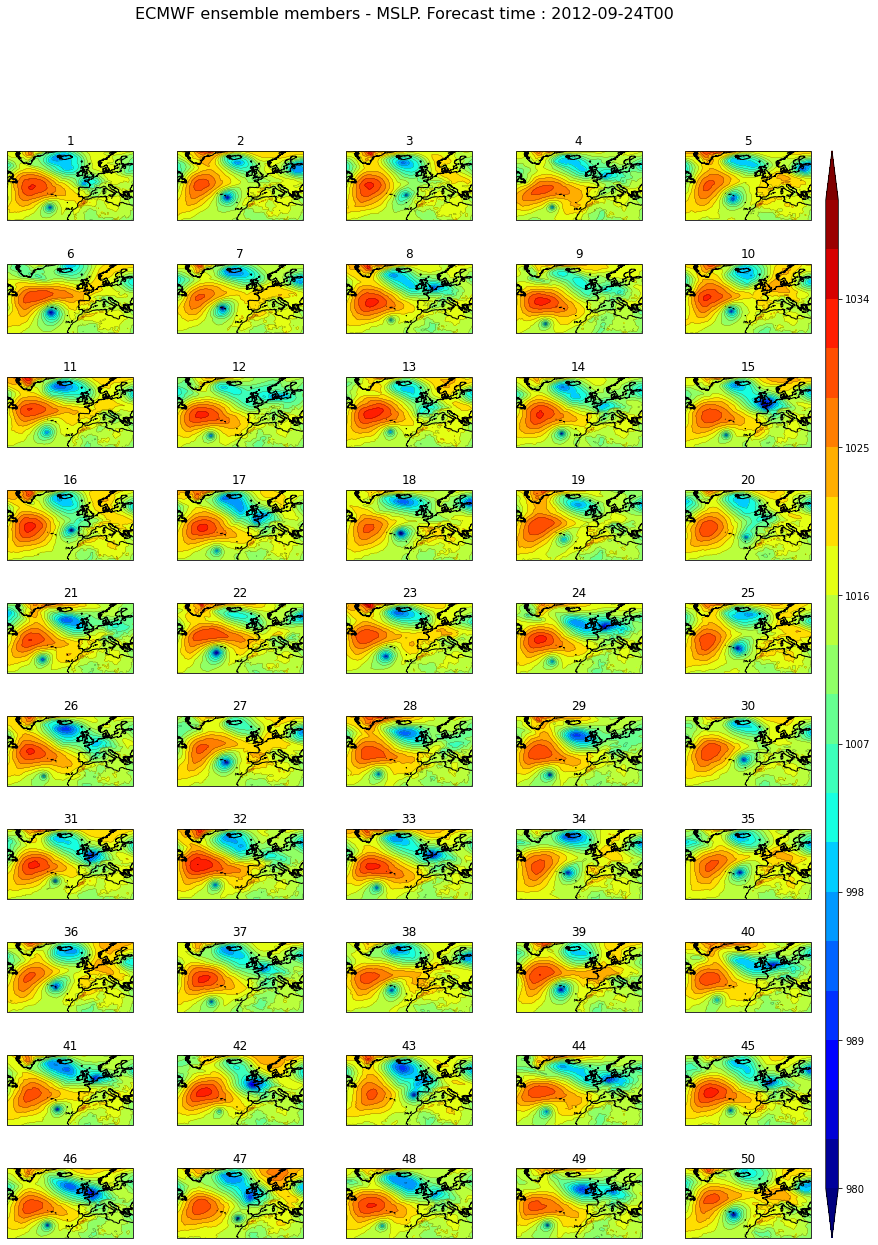

In [30]:
plt_title = 'ECMWF ensemble members - MSLP. Forecast time : '+date_str
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(20,20))
fig.suptitle(plt_title, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(10, 5),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='1%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    ax.coastlines()
    ax.set_title(str(i+1), fontsize=12)
    p1 = ax.contourf(lons_mslp0, lats_mslp0, mslp_ens[i,:,:], clevs2, transform=ccrs.PlateCarree()
                     , cmap=cmap, extend='both')
    p2 = ax.contour(lons_mslp0, lats_mslp0, mslp_ens[i,:,:], clevs2, colors='black'
                   , linewidths=0.2, transform=ccrs.PlateCarree())
    axgr.cbar_axes[i].colorbar(p1)

plt.show()

figname='./figs/MSLP_ENS_'+date_str
fig.savefig(figname+'.png')

# Partie 2 : analyse en composantes principales

In [34]:
data    = xr.open_dataset(EPS_Z500).sel(lat=slice(maxlat,minlat)).sel(lon=slice(minlon,maxlon)).sel(time=date).squeeze()

lats=data.lat.values
lons=data.lon.values
print(data)

z=data['var129']/9.81
z=np.array(z[:,:,:])

<xarray.Dataset>
Dimensions:  (lon: 61, lat: 41, time: 50)
Coordinates:
  * lon      (lon) float64 -10.0 -9.5 -9.0 -8.5 -8.0 ... 18.5 19.0 19.5 20.0
  * lat      (lat) float64 55.0 54.5 54.0 53.5 53.0 ... 37.0 36.5 36.0 35.5 35.0
    lev      float64 5e+04
  * time     (time) datetime64[ns] 2012-09-24 2012-09-24 ... 2012-09-24
Data variables:
    var129   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.4.3
    Conventions:  CF-1.0
    history:      Tue Aug 20 18:21:47 2019: cdo -f nc copy EPS_2012092000_Z50...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.4.3 (http://www.mpimet.mpg...


In [35]:
z_mean = z.mean(axis=0)
z_anom = z - z_mean

In [44]:
wgts = np.sqrt(np.cos(np.deg2rad(lats)))[:, np.newaxis]
solver = Eof(z_anom, weights=wgts, center=False)
eofs = solver.eofs(neofs=neofs)
pcs = solver.pcs(npcs=neofs, pcscaling=0)
varfrac = solver.varianceFraction()

print(eofs.shape)
print(pcs.shape)

print(np.max(eofs))
print(np.min(eofs))

print(np.max(pcs))
print(np.min(pcs))

(2, 41, 61)
(50, 2)
0.03715260062817803
-0.0398246036342227
3235.4468407178697
-3367.5985095244364


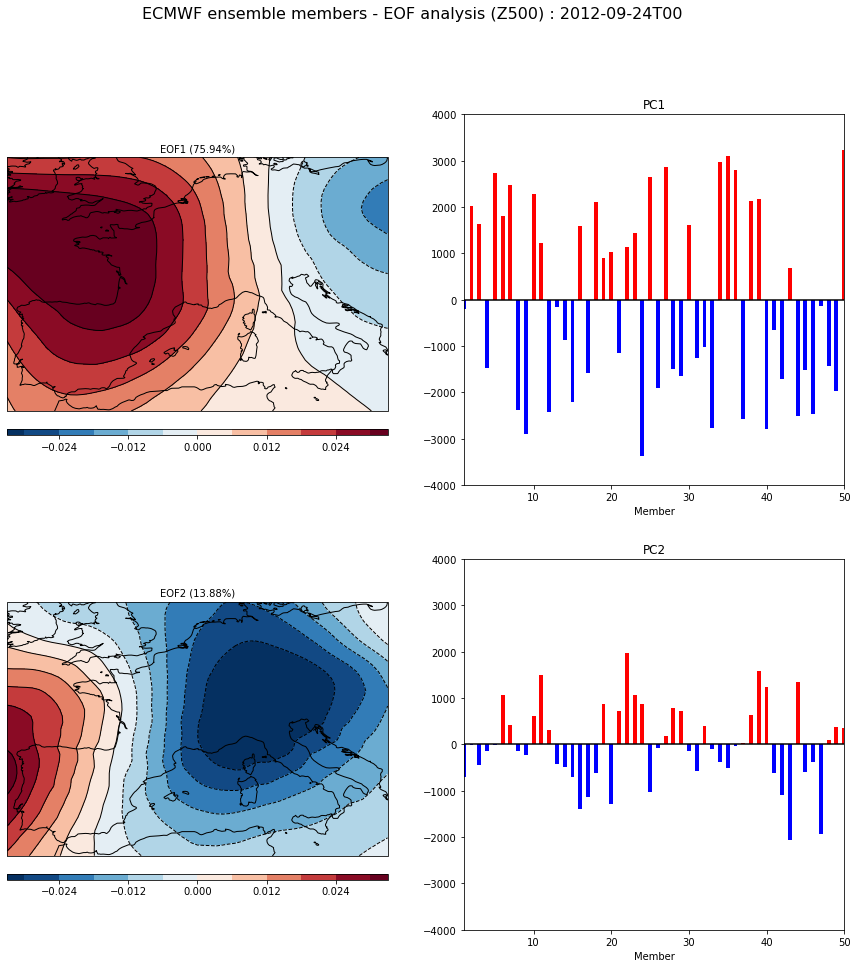

In [48]:
clevs = np.linspace(-0.03, 0.03, 11)

fig = plt.figure(figsize=(15, 15))
fig.suptitle('ECMWF ensemble members - EOF analysis (Z500) : '+date_str, fontsize=16)

ax = fig.add_subplot(221, projection=ccrs.PlateCarree())
varfrac1=round(varfrac[0]*100,2)
plt.title('EOF1 ('+str(varfrac1)+'%)', fontsize=10, loc='center')
ax.coastlines()
cf = ax.contourf(lons, lats, eofs[0], levels=clevs, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
c = ax.contour(lons, lats, eofs[0], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')


ax = fig.add_subplot(222)
plt.title('PC1')
plt.xlabel('Member')
pc1=np.asarray(pcs[:,0])
colormat=np.where(pc1>0, 'red','blue')
plt.bar(members, pc1, width=0.5, color=colormat)
plt.axhline(0, color='k')
ax.set_ylim(-4000, 4000)
ax.set_xlim(1, 50)

ax = fig.add_subplot(223, projection=ccrs.PlateCarree())
varfrac2=round(varfrac[1]*100,2)
plt.title('EOF2 ('+str(varfrac2)+'%)', fontsize=10, loc='center')
ax.coastlines()
cf = ax.contourf(lons, lats, eofs[1], levels=clevs, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
c = ax.contour(lons, lats, eofs[1], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')

ax = fig.add_subplot(224)
plt.title('PC2')
plt.xlabel('Member')
pc2=np.asarray(pcs[:,1])
colormat=np.where(pc2>0, 'red','blue')
plt.bar(members, pc2, width=0.5, color=colormat)
plt.axhline(0, color='k')
ax.set_ylim(-4000, 4000)
ax.set_xlim(1, 50)

figname='./figs/eof1_pc1_z500_'+date_str
fig.savefig(figname+'.png')

plt.show()

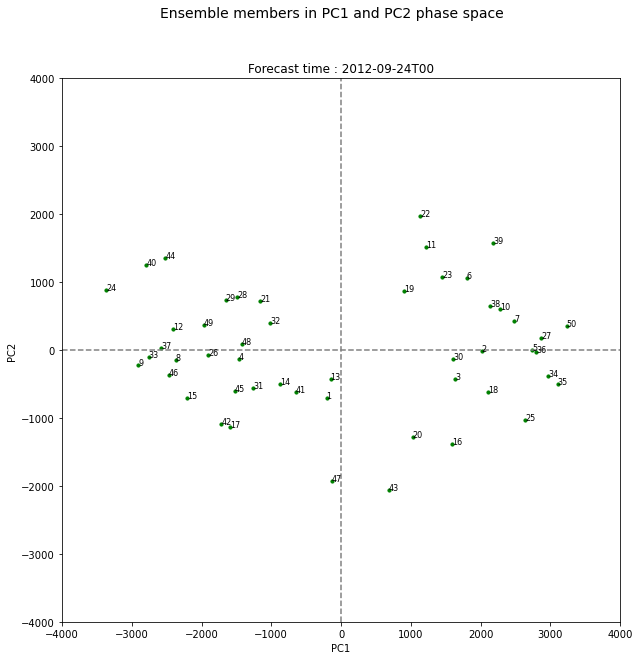

In [54]:
def plot_phase_space(ax):
    plt.title('Forecast time : '+date_str)
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xlim(-4000, 4000)
    plt.ylim(-4000, 4000)
    return ax

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
fig.suptitle('Ensemble members in PC1 and PC2 phase space', fontsize=14)
plot_phase_space(ax)
plt.scatter(pcs[:,0],pcs[:,1], c = 'g', s=10)

for i,type in enumerate(members_str):
    x = pcs[i,0]
    y = pcs[i,1]
    plt.text(x, y, type, fontsize=8)

plt.show()

figname='./figs/z500_PC_2d_phase space_'+date_str
fig.savefig(figname+'.png')

# Partie 3 : classification

In [50]:
# Clustering
kmeans = KMeans(n_clusters=nclusters)
# Fitting the input data
kmeans = kmeans.fit(pcs)
# Getting the cluster labels
labels = kmeans.predict(pcs)
# Centroid values
centroids = kmeans.cluster_centers_

nc1=list(labels[:]).count(0)
nc2=list(labels[:]).count(1)

print(labels)
print(labels.shape)
print(centroids)
print(centroids.shape)

[0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0
 1 1 0 0 0 1 0 0 0 0 0 0 1]
(50,)
[[-1725.67927946   -88.25440873]
 [ 2025.79788119   103.60391794]]
(2, 2)


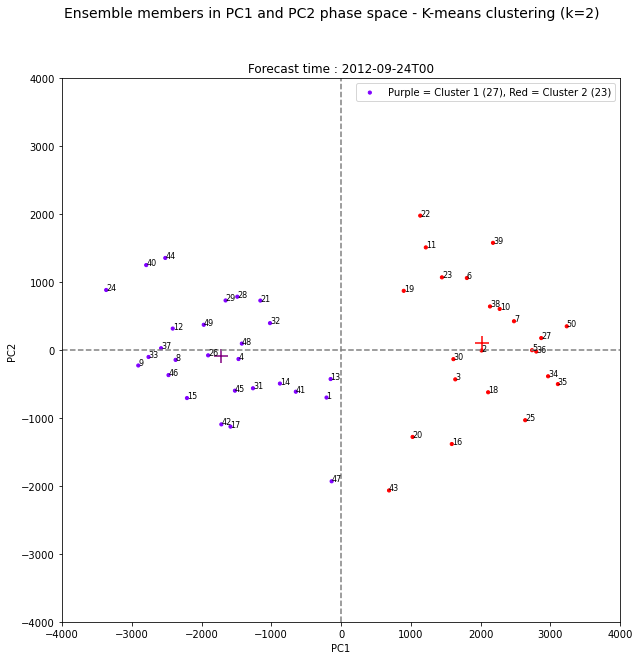

In [52]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
fig.suptitle('Ensemble members in PC1 and PC2 phase space - K-means clustering (k=2)', fontsize=14)
plot_phase_space(ax)
plt.scatter(pcs[:,0], pcs[:,1], c=labels, s=10, cmap='rainbow',
 label='Purple = Cluster 1 ('+str(nc1)+'), Red = Cluster 2 ('+str(nc2)+')')
plt.scatter(centroids[:, 0], centroids[:, 1], c=['purple','red'], s=200, alpha=1, marker='+');

for i,type in enumerate(members_str):
    x = pcs[i,0]
    y = pcs[i,1]
    plt.text(x, y, type, fontsize=8)

plt.legend()
plt.show()

figname='./figs/Z500_PC_2d_phase space_2clusters_'+date_str
fig.savefig(figname+'.png')

# Partie 4 : composites

In [55]:
id_cluster1=np.any([labels==0],axis=0)
id_cluster2=np.any([labels==1],axis=0)

z_c1 = z_ens[id_cluster1,:,:].mean(axis=0)
z_c2 = z_ens[id_cluster2,:,:].mean(axis=0)
mslp_c1 = mslp_ens[id_cluster1,:,:].mean(axis=0)
mslp_c2 = mslp_ens[id_cluster2,:,:].mean(axis=0)

print(z_c1.shape)
print(mslp_c1.shape)

(101, 181)
(178, 321)


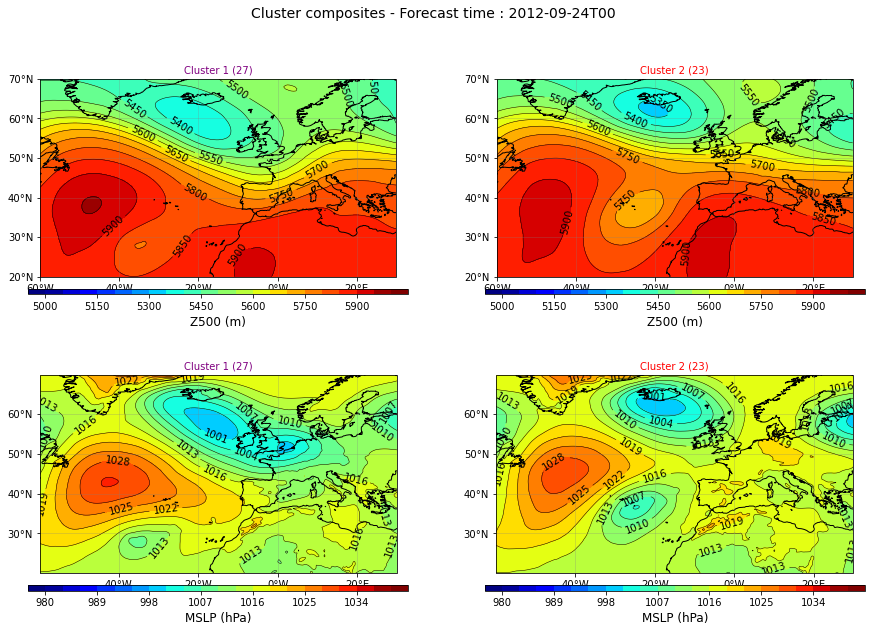

In [58]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Cluster composites - Forecast time : '+date_str, fontsize=14)

ax = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
plt.title('Cluster 1 ('+str(nc1)+')', color='purple', fontsize=10, loc='center')
plot_background(ax)
cf = ax.contourf(lons_z0, lats_z0, z_c1, levels=clevs1, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
c = ax.contour(lons_z0, lats_z0, z_c1, levels=clevs1, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
ax.clabel(c, fmt='%4.1i', fontsize=10)
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Z500 (m)', fontsize=12)

ax = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())
plt.title('Cluster 2 ('+str(nc2)+')', color='red', fontsize=10, loc='center')
plot_background(ax)
cf = ax.contourf(lons_z0, lats_z0, z_c2, levels=clevs1, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
c = ax.contour(lons_z0, lats_z0, z_c2, levels=clevs1, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
ax.clabel(c, fmt='%4.1i', fontsize=10)
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Z500 (m)', fontsize=12)

ax = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
plt.title('Cluster 1 ('+str(nc1)+')', color='purple', fontsize=10, loc='center')
plot_background(ax)
cf = ax.contourf(lons_mslp0, lats_mslp0, mslp_c1, levels=clevs2, cmap=cmap, extend='both'
                 , transform=ccrs.PlateCarree())
c = ax.contour(lons_mslp0, lats_mslp0, mslp_c1, levels=clevs2, colors='black', linewidths=0.5
               , transform=ccrs.PlateCarree())
ax.clabel(c, fmt='%4.1i', fontsize=10)
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('MSLP (hPa)', fontsize=12)

ax = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
plt.title('Cluster 2 ('+str(nc2)+')', color='red', fontsize=10, loc='center')
plot_background(ax)
cf = ax.contourf(lons_mslp0, lats_mslp0, mslp_c2, levels=clevs2, cmap=cmap, extend='both'
                 , transform=ccrs.PlateCarree())
c = ax.contour(lons_mslp0, lats_mslp0, mslp_c2, levels=clevs2, colors='black', linewidths=0.5,
               transform=ccrs.PlateCarree())
ax.clabel(c, fmt='%4.1i', fontsize=10)
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('MSLP (hPa)', fontsize=12)

plt.show()

figname='./figs/Composites_Z500_MSLP_'+date_str
fig.savefig(figname+'.png')

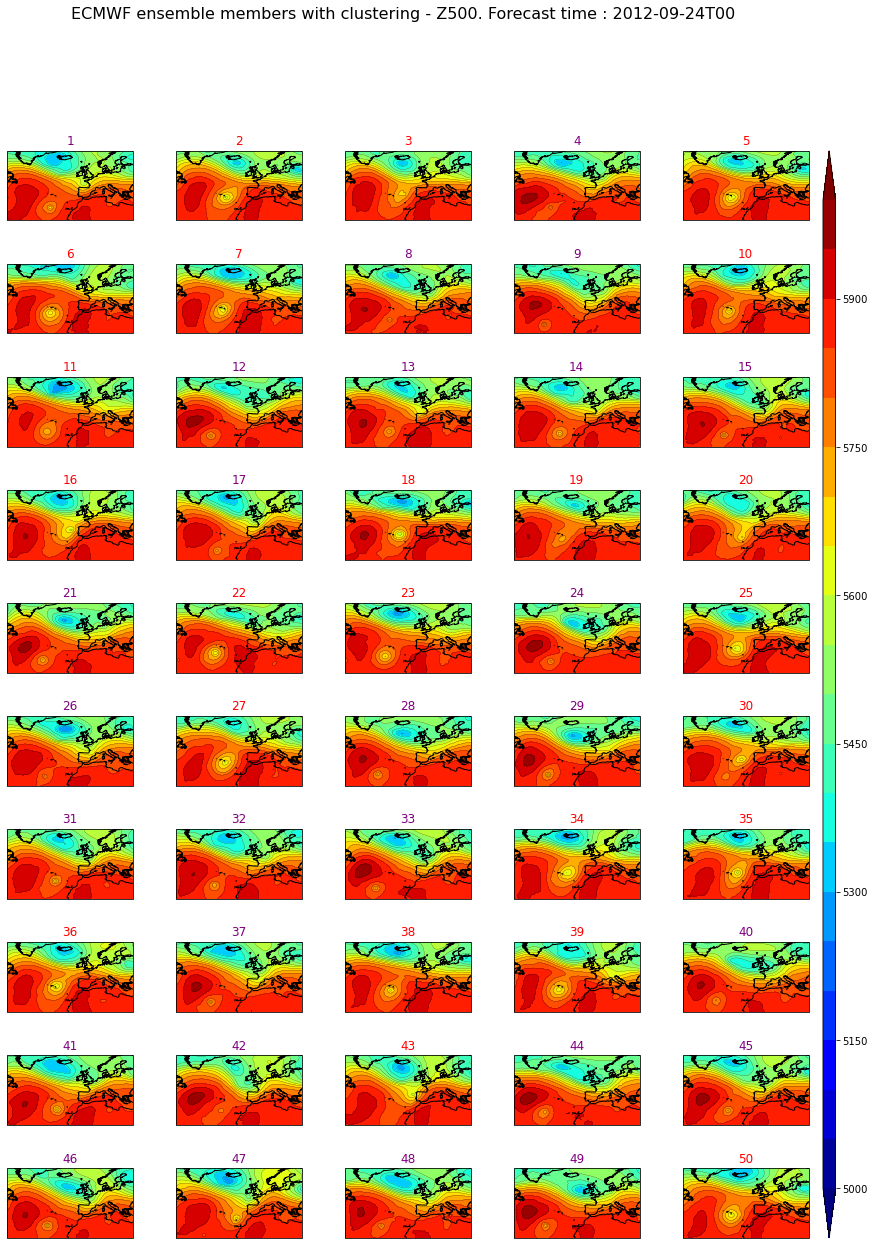

In [61]:
#create color array
color=[""]*len(labels)
couleur=["purple","red"]
for i in range(len(labels)):
 color[i]=couleur[labels[i]]
 
plt_title = 'ECMWF ensemble members with clustering - Z500. Forecast time : '+date_str
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(20,20))
fig.suptitle(plt_title, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(10, 5),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='1%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
   ax.coastlines()
   ax.set_title(str(i+1), color=color[i], fontsize=12)
   p1 = ax.contourf(lons_z0, lats_z0, z_ens[i,:,:], clevs1, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
   p2 = ax.contour(lons_z0, lats_z0, z_ens[i,:,:], clevs1, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())
   axgr.cbar_axes[i].colorbar(p1)
   
plt.show()

figname='./figs/z500_ENS_cluster_'+date_str
fig.savefig(figname+'.png')

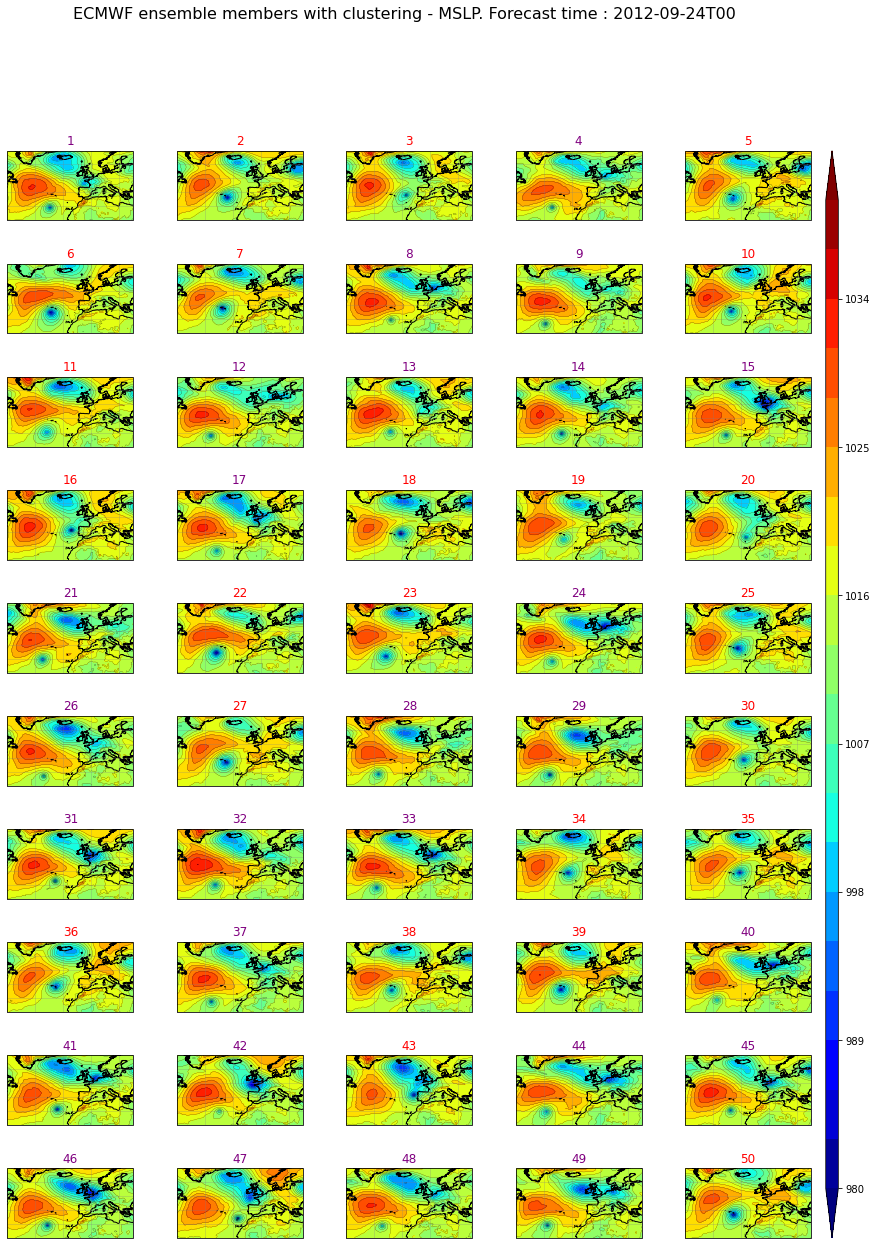

In [62]:
plt_title = 'ECMWF ensemble members with clustering - MSLP. Forecast time : '+date_str
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(20,20))
fig.suptitle(plt_title, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(10, 5),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='1%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
   ax.coastlines()
   ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
   ax.set_title(str(i+1), color=color[i], fontsize=12)
   p1 = ax.contourf(lons_mslp0, lats_mslp0, mslp_ens[i,:,:], clevs2, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
   p2 = ax.contour(lons_mslp0, lats_mslp0, mslp_ens[i,:,:], clevs2, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())
   axgr.cbar_axes[i].colorbar(p1)
   
plt.show()

figname='./figs/MSLP_ENS_cluster_'+date_str
fig.savefig(figname+'.png')